# Exploring burger joints in São Paulo through the Foursquare API

###    This jupyter notebook is dedicated to exploring burger joint venues in São Paulo, Brazil as a part of IBM Data Science Capstone Project. 

###    The objective is to cluster the venues based on their characteristics and then extract customer information about each cluster.This will not only bring insights about the types of burguer joints in São Paulo, but will also bring insights about what customers value the most, dependending on the type of venue.



### This notebook is divided into 8 sections: 

   - Introduction and data acquisition
   - Preprocessing the data
   - Clustering and evaluation of clustering method
   - Cluster Analysis
   - Word Cloud of the clusters
   - Conclusion
   - Appendix
   - References

--------------------------------------------------------------

# __Introduction and data acquisition__

-----------

### First we will import all necessary libraries

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from urllib.request import urlopen
import bs4
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-prototype from clustering stage
!pip install kmodes
from kmodes.kprototypes import KPrototypes

!conda install -c conda-forge folium=0.5.0 --yes 
import folium # map rendering library

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

# !conda install --channel conda-forge geopandas --yes
# !pip install --upgrade bs4
# !pip install lxml
# !pip install jupyterlab==1.2 "ipywidgets>=7.5"

# # Avoid "JavaScript heap out of memory" errors during extension installation
# # (OS X/Linux)
# !export NODE_OPTIONS=--max-old-space-size=4096


# # Jupyter widgets extension
# !jupyter labextension install @jupyter-widgets/jupyterlab-manager@1.1 --no-build

# # jupyterlab renderer support
# !jupyter labextension install jupyterlab-plotly@4.6.0 --no-build

# # FigureWidget support
# !jupyter labextension install plotlywidget@4.6.0 --no-build

# # Build extensions (must be done to activate extensions since --no-build is used above)
# !jupyter lab build

# # Unset NODE_OPTIONS environment variable
# # (OS X/Linux)
# !unset NODE_OPTIONS

%matplotlib inline

from sklearn.preprocessing import MinMaxScaler,StandardScaler

print('Libraries imported.')




Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.

Libraries imported.


### Client ID and Secret to connect to the Foursquare API


In [ ]:
CLIENT_ID = '$YourID' # your Foursquare ID
CLIENT_SECRET = '$YourSecret' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

### Setting up the request to get the burger venues in São Paulo

In [149]:
LIMIT = 1000
radius = 10000
latitudeSP=-23.5506507
longitudeSP=-46.6333824

In [199]:
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&query={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitudeSP, 
    longitudeSP, 
    radius, 
    LIMIT,
    'burguer'
)

In [200]:
results = requests.get(url).json()
print(results)

{'meta': {'code': 200, 'requestId': '5e8ccce2f7706a001be207db'}, 'response': {'suggestedFilters': {'header': 'Tap to show:', 'filters': [{'name': 'Open now', 'key': 'openNow'}]}, 'headerLocation': 'São Paulo', 'headerFullLocation': 'São Paulo', 'headerLocationGranularity': 'city', 'query': 'burguer', 'totalResults': 146, 'suggestedBounds': {'ne': {'lat': -23.46065060999991, 'lng': -46.53538813506399}, 'sw': {'lat': -23.640650790000088, 'lng': -46.731376664936015}}, 'groups': [{'type': 'Recommended Places', 'name': 'recommended', 'items': [{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '537d3a2a498e3b8f36658622', 'name': 'Holy Burger', 'location': {'address': 'R. Dr. Cesário Mota Júnior, 527', 'lat': -23.54656404826489, 'lng': -46.649005704756796, 'labeledLatLngs': [{'label': 'display', 'lat': -23.54656404826489, 'lng': -46.649005704756796}], 'distance': 1657, 'postalCode': '01221-020'

#### Using a fuction to retrieve the category type of each venue

In [201]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [ ]:
venues = results['response']['groups'][0]['items']
nearby_venues = json_normalize(venues) 
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng','venue.id']
nearby_venues =nearby_venues.loc[:, filtered_columns]


nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)


nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]



### Now that we retrieved the burger joints in São Paulo, we need to retrieve the longitude and latitude of each neighborhood

In [202]:
geolocator_hood = Nominatim(timeout=5)


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning:

Using Nominatim with the default "geopy/1.21.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.



### Importing excel to get the neighborhoods in São Paulo and using geopy to get the neighborhood latitude and longitude

In [209]:
data_hoods= pd.read_excel('Neighborhoods_SP.xlsx')

In [210]:
data_hoods= pd.read_excel('Neighborhoods_SP.xlsx')
geolocator = Nominatim()
from geopy.exc import GeocoderTimedOut
lat=[]
lon=[]
for i in data_hoods['Neighborhood']:
    try:
        location_hood = geolocator.geocode("{}, Sao Paulo,Sao Paulo".format(i))
        print(i)
        lat.append(location_hood.latitude)
        lon.append(location_hood.longitude)
    except GeocoderTimedOut:
        location_hood = geolocator.geocode("{}, Sao Paulo,Sao Paulo".format(i))
        print(i)
        lat.append(location_hood.latitude)
        lon.append(location_hood.longitude)
        





/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning:

Using Nominatim with the default "geopy/1.21.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.



Moema
Ibirapuera
Vila Olimpia
Vila Madalena
Alto de Pinheiros
Consolacao
Vila Clementino
Campo Belo
Alto da Boa Vista
Brooklin
Vila Mariana
Perdizes
Bela Vista
Aclimacao
Liberdade
Saude
Lapa
Vila Mascote
Tatuape
Alto da Lapa
Santana
Santo Amaro
Vila Leopoldina
Ipiranga
Jardim da Saude
Bosque da Saude
Mooca
Jardim Marajoara
Mandaqui
Barra Funda
Santa Cecilia
Morumbi
Vila Gumercindo
Cambuci
Jaguare
Bom Retiro
Belem
Agua Branca
Jabaquara
Vila Maria
Jurubatuba
Vila Guilherme
Pari
Butantã
Casa Verde
Sacomã
Vila Formosa
Bras
Limão
Vila Carrao
Vila das Merces
Tucuruvi
Freguesia do Ó
Moinho Velho
Cupece
Luz
Vila Prudente
São Joao Climaco
Campo Grande
Penha
Vila Matilde
Pirituba
Cidade Ademar
Vila Antonieta
Brasilandia
Americanopolis
Jardim Aricanduva
Interlagos
Campo Limpo
São Mateus
Itaquera


In [213]:
data_hoods['lat']=lat
data_hoods['lon']=lon

### There was some neighborhoods that were not found by geopy, so we need to introduce them manually

In [214]:
data_hoods_rest= pd.read_excel('separate_neighborhoods.xlsx')
data_hoods_rest

Neighborhood        lat        lon
0  Chacara Santo Antonio -23.634126 -46.708195
1           Higienopolis -23.546054 -46.659447
2          Jardim Europa -23.577544 -46.683721
3                Paraiso -23.575712 -46.650789
4    Vila Nova Conceicao -23.591162 -46.669793
5                 Sumaré -23.544008 -46.685143
6              Pinheiros -23.563551 -46.691597
7        Jardim Paulista -23.570968 -46.658233
8             Itaim Bibi -23.583656 -46.677918

### concatenating the neighborhoods which could not be found in geopy

In [215]:
data_hoods=pd.concat([data_hoods,data_hoods_rest])
data_hoods.reset_index(drop=True,inplace=True)
data_hoods

Neighborhood        lat        lon
0                 Moema -23.594585 -46.661801
1            Ibirapuera -23.576952 -46.654635
2          Vila Olimpia -23.594028 -46.684219
3         Vila Madalena -23.546496 -46.691124
4     Alto de Pinheiros -23.549549 -46.712155
..                  ...        ...        ...
75  Vila Nova Conceicao -23.591162 -46.669793
76               Sumaré -23.544008 -46.685143
77            Pinheiros -23.563551 -46.691597
78      Jardim Paulista -23.570968 -46.658233
79           Itaim Bibi -23.583656 -46.677918

[80 rows x 3 columns]

### getting the burger venues within a radius of 900 meters 

In [216]:
def getNearbyVenues(names, latitudes, longitudes, radius=900):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&query={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT,
            'burguer'
        )
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['id']) for v in results])

    burguer_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    burguer_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Id']
    
    return(burguer_venues)

In [ ]:
SP_burguer_venues = getNearbyVenues(names=data_hoods['Neighborhood'],
                                   latitudes=data_hoods['lat'],
                                   longitudes=data_hoods['lon']
                                  )

### checking for duplicates in case of venue overlap

In [3]:
pd.value_counts(SP_burguer_venues['Venue Id'])

NameError: name 'pd' is not defined

In [220]:
SP_burguer_venues.groupby(SP_burguer_venues['Neighborhood'])

In [221]:
SP_burguer_venues.drop_duplicates(subset ='Venue Id', 
                     keep = 'first', inplace = True) 
SP_burguer_venues.reset_index(drop=True,inplace=True)  

### Mapping the burger joints without duplicates

In [222]:
map_burguers_neigh = folium.Map(location=[latitudeSP,longitudeSP], zoom_start=11)

for lat, lon, name in zip(SP_burguer_venues['Venue Latitude'], SP_burguer_venues['Venue Longitude'], SP_burguer_venues['Venue']):
    label = folium.Popup(' name ' + str(name), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.7).add_to(map_burguers_neigh)
       
map_burguers_neigh

### As shown in the map, there is a massive number of burger joints in São Paulo. 

#### In some regions, this could actually be a saturated market, for example in the Itaim Bibi Neighborhood, we have more than 25 burger joints (just counting the ones that are registered in foursquared).

#### The idea here is to gather information that will help us get insights about these venues.

#### In the case of this study, 4 types of information were chosen that will help us cluster the venues and also give us insights about the types of customers that attend these venues:

- Venue Rating: A straightforward way to differentiate between the venues. We will retrieve the best venues by requesting the venue rating from the foursqaure API. This data is a rating that varies from 0-10.

- Venue Price: Comma separated list of price points. Currently the valid range of price points are [1,2,3,4], 1 being the least expensive, 4 being the most expensive. 1 is < 10 USD an entree, 2 is 10 to 20 USD an entree, 3 is 20 to 30 USD an entree, 4 is > 30 USD an entree. This data is also within the json from the Foursquare API response. 

- Venue Review: A text review of a customer that attended to a specific venue registered in the Foursquare platform. This will be used to give us more qualitative insights about what the customers value the most.

- Neighborhood meter squared price: This is the real estate price per meter squared of a specific neighborhood. This will help retrieve insights about not only the cost of maintaining a venue but also the type of customer that attends that venue if we assume that the higher the real estate price of a certain area, the higher the purchase power of a person that lives in that area. This feature is measured in Reais (R$).

### We currently have data on neighborhood location, venue and venue ID.

In [223]:
SP_burguer_venues

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0          Moema             -23.594585              -46.661801   
1          Moema             -23.594585              -46.661801   
2          Moema             -23.594585              -46.661801   
3          Moema             -23.594585              -46.661801   
4          Moema             -23.594585              -46.661801   
..           ...                    ...                     ...   
292   Itaim Bibi             -23.583656              -46.677918   
293   Itaim Bibi             -23.583656              -46.677918   
294   Itaim Bibi             -23.583656              -46.677918   
295   Itaim Bibi             -23.583656              -46.677918   
296   Itaim Bibi             -23.583656              -46.677918   

                   Venue  Venue Latitude  Venue Longitude  \
0         Chicohamburger      -23.600686       -46.659306   
1                  Tradi      -23.595413       -46.666676   
2               Bullguer      -23.597058       -46.667724   
3               Stop Dog      -23.595320       -46.670190   
4                America      -23.597604       -46.667176   
..                   ...             ...              ...   
292  Classic Burger Haüs      -23.583059       -46.676177   
293      Varanda Burguer      -23.582869       -46.669926   
294               Achapa      -23.580422       -46.674754   
295          TheDog Haüs      -23.583016       -46.676225   
296           Dona Deôla      -23.586195       -46.680645   

                     Venue Id  
0    4b30180ef964a520f6f524e3  
1    56633f71498ec93dd3483489  
2    5506eeac498e2883360e7b7d  
3    4b4fb4e6f964a520d41127e3  
4    4b2b99e8f964a52013b824e3  
..                        ...  
292  564bd2e3498e1cba92476299  
293  56bb905c498e886d33450790  
294  51c88f78498edb10ae45797d  
295  5058b9cae4b0700b20010a3b  
296  5384815d498e59fb623fcc3d  

[297 rows x 7 columns]

### Now we get the rating, review and price information from the venues

In [224]:
def getVenuesinfo(venue,names,venue_id):
    jsondict={}
    for ven,name, v_id in zip(venue,names,venue_id):
        print(name)
            
        # create the API request URL
        url_venue = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            v_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION 
        )
            
        # make the GET request
        results_venues = requests.get(url_venue).json()
        jsondict[v_id]=results_venues
        
    
    
    return(jsondict)

In [225]:
SP_burguer_info = getVenuesinfo(venue=SP_burguer_venues['Venue'],names=SP_burguer_venues['Neighborhood'],
                                   venue_id=SP_burguer_venues['Venue Id']
                                  )

Moema
Moema
Moema
Moema
Moema
Moema
Ibirapuera
Ibirapuera
Ibirapuera
Ibirapuera
Ibirapuera
Ibirapuera
Ibirapuera
Ibirapuera
Vila Olimpia
Vila Olimpia
Vila Olimpia
Vila Olimpia
Vila Olimpia
Vila Olimpia
Vila Olimpia
Vila Olimpia
Vila Olimpia
Vila Olimpia
Vila Olimpia
Vila Olimpia
Vila Olimpia
Vila Olimpia
Vila Olimpia
Vila Olimpia
Vila Olimpia
Vila Olimpia
Vila Madalena
Vila Madalena
Vila Madalena
Alto de Pinheiros
Consolacao
Consolacao
Consolacao
Consolacao
Consolacao
Consolacao
Consolacao
Consolacao
Consolacao
Consolacao
Consolacao
Consolacao
Consolacao
Consolacao
Consolacao
Consolacao
Consolacao
Consolacao
Consolacao
Consolacao
Consolacao
Consolacao
Consolacao
Consolacao
Consolacao
Consolacao
Consolacao
Consolacao
Consolacao
Consolacao
Consolacao
Consolacao
Consolacao
Consolacao
Consolacao
Vila Clementino
Vila Clementino
Vila Clementino
Vila Clementino
Vila Clementino
Vila Clementino
Campo Belo
Campo Belo
Campo Belo
Campo Belo
Campo Belo
Brooklin
Brooklin
Brooklin
Vila Mariana
Vila M

### extracting the reviews and the ratings from the retrieved json responses

In [228]:
reviews=[]
review_list=[]
rating_list=[]
ven_id=[]

for i in SP_burguer_venues['Venue Id']:
    print(i)
    
    try:
        rating_list.append(SP_burguer_info[i]['response']['venue']['rating'])
    except KeyError:
        rating_list.append('no rating')


for i in SP_burguer_venues['Venue Id']:
    review_list=[]
    ven_id.append(i)
    for x in SP_burguer_info[i]['response']['venue']['tips']['groups'][0]['items']:
        try:
            review_list.append(x['text'])
            
        except KeyError:
            review_list.append('no review')
        
    reviews.append(review_list)





4b30180ef964a520f6f524e3
56633f71498ec93dd3483489
5506eeac498e2883360e7b7d
4b4fb4e6f964a520d41127e3
4b2b99e8f964a52013b824e3
4b2e55b1f964a5206dde24e3
50f88bd7e4b0ff62a1e089b5
4b072ca2f964a520caf822e3
57410a08498e7647f807fe82
4b563d78f964a520f60628e3
55149e22498ead17c7b2732c
56bd1608498e38ac825a6c1b
528e2a7511d24bd1f94d3db8
4be8212fee96c928b8adfdbf
5182980d498ee2fcca64b47d
4ff47b35e4b025109910da35
4b0bdfd7f964a520573423e3
59d65932a795bd637857fa28
50d3958ee4b05708575747c3
5d65c34f9448680008d1c8d6
4bb36dfba32876b0a9a801fe
4e56a24ec65be3cea468f634
4b1eaab3f964a520831d24e3
4f106d06e4b0d59e1ee52310
59c11a62db1d8147ca3f91af
550c49ae498e0d328db718c9
4fe4fdb0e4b04d88c5c34041
51cf3285498e00f5060bcc1f
4f5883c8e4b0882cd6b6c7fc
4bc88c4892b376b09697513a
4fbfc522e4b099ce167f89bf
4b1aa0c5f964a520cded23e3
53e95dc1498e13fbab4ce948
59c40f04e1f0aa4b92c7f81b
53d1213f498e98bfa2b76e70
4b508dddf964a5201e2727e3
4b0d495df964a520ab4523e3
4b09d590f964a5206f1e23e3
4b192079f964a52049d823e3
4b0acd14f964a5200a2823e3


In [229]:
price_list=[]
for i in SP_burguer_venues['Venue Id']:
    
    try:
        price_list.append(SP_burguer_info[i]['response']['venue']['attributes']['groups'][0]['items'][0]['priceTier'])

    except KeyError:
        price_list.append('no price')
    except IndexError:
        price_list.append('no price')
        
    

In [231]:
price_dict={'Price':price_list}
price=pd.DataFrame(price_dict)
SP_burguer_venues=SP_burguer_venues.join(price)

reviews_dict={'Review':reviews}
reviews=pd.DataFrame(reviews_dict)

SP_burguer_venues=SP_burguer_venues.join(reviews)

rating_dict={'Rating':rating_list}

rating=pd.DataFrame(rating_dict)
SP_burguer_venues=SP_burguer_venues.join(rating)

In [2]:
SP_burguer_venues = pd.read_csv(r'SP_Burger_Venues.csv') 

SP_burguer_venues

NameError: name 'pd' is not defined

In [233]:
# SP_burguer_venues.to_csv(r'/Users/guilhermecosta 1/repos/Coursera_Capstone/SP_Burger_Venues.csv',index=False)

### Now we will include the price per meter squared of each venue based on which neighborhood it belongs to.

In [240]:
data_price_m2= pd.read_excel('neigh_m2.xlsx')
data_price_m2['Neighborhood']

In [243]:
price_m2_list=[]

for n in SP_burguer_venues['Neighborhood']:
    for k,i in zip(data_price_m2['Neighborhood'],data_price_m2.index):
        if  k==n:
            price_m2_list.append(data_price_m2['M2_price'][i])
        else:
            pass



In [244]:
price_list={'Price_M2':price_m2_list}
price_list=pd.DataFrame(price_list)
SP_burguer_venues=SP_burguer_venues.join(price_list)
SP_burguer_venues['Price_M2']=price_list

--------------
# __Preprocessing the data__

--------------

#### Removing the venues that have no price and no rating.

In [245]:
print((SP_burguer_venues['Price']=='no price').value_counts())

print((SP_burguer_venues['Rating']=='no rating').value_counts())

False    273
True      24
Name: Price, dtype: int64
False    281
True      16
Name: Rating, dtype: int64


In [246]:
SP_burguer_venues.groupby('Neighborhood')

### filtering only the features that we are going to use for the clustering

In [247]:
indexNames = SP_burguer_venues[(SP_burguer_venues['Price'] == 'no price')].index
SP_burguer_venues.drop(indexNames , inplace=True)
indexNames = SP_burguer_venues[(SP_burguer_venues['Rating'] == 'no rating')].index
SP_burguer_venues.drop(indexNames , inplace=True)


cluster_df=SP_burguer_venues.filter(['Rating','Price_M2','Price'], axis=1)



---------------
# __Clustering and evaluation of the clustering method__

---------------

### Now, we have our dataset ready for clustering. The trick here is that we have mixed data. This can be rather dificult to cluster because it is difficult for an algorithm to determine the distance betweeten intracluster elements using categorical data. 

### On the other hand, our data is not purelly categorical, its ordinal data. This means that if we treat this type of data as categorical, we will loose all the information regarding the order of that specific feature. For this reason, I will be treating all features as numeric and will be using __k-means__ to determine the clusters. 

##### note: On the appendix I have made the same clustering but using __k-prototypes__ that accepts both categorical and numeric data. It's a really useful tool when dealing with real world data, so make sure you check that out.

__________________________

### Standardizing the data and finding out the best number of clusters using the elbow method

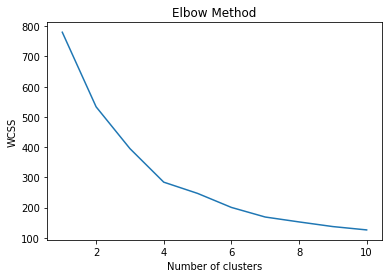

In [505]:
from sklearn.cluster import KMeans


Clus_dataSet=StandardScaler().fit_transform(cluster_df)
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(Clus_dataSet)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

### Now running the k-means using 4 clusters (where there is the elbow)

In [509]:
# set number of clusters
kclusters = 4

Clus_dataSet=StandardScaler().fit_transform(cluster_df)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Clus_dataSet)


SP_burguer_venues.drop(columns=['Cluster Labels'],inplace=True)
SP_venues_clustered=SP_burguer_venues.insert(0, 'Cluster Labels', kmeans.labels_)

### Below is a map of the cluters spread through the region of São Paulo

In [510]:
map_clusters = folium.Map(location=[latitudeSP,longitudeSP], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(SP_burguer_venues['Venue Latitude'], SP_burguer_venues['Venue Longitude'], SP_burguer_venues['Neighborhood'], SP_burguer_venues['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Assigning the clusters to separate data frames so we can better analyze them in the next section

In [511]:
#SP_burguer_venues
cluster1=SP_burguer_venues.loc[SP_burguer_venues['Cluster Labels'] == 0]
cluster1.reset_index(drop=True,inplace=True)
cluster2=SP_burguer_venues.loc[SP_burguer_venues['Cluster Labels'] == 1]
cluster2.reset_index(drop=True,inplace=True)
cluster3=SP_burguer_venues.loc[SP_burguer_venues['Cluster Labels'] == 2]
cluster3.reset_index(drop=True,inplace=True)
cluster4=SP_burguer_venues.loc[SP_burguer_venues['Cluster Labels'] == 3]
cluster4.reset_index(drop=True,inplace=True)



----------------
#   Cluster Analysis 

-------------

### 3D Mapping of the clusters based on their characteristics


##### note: If the label data is numeric, plotly understands it as continuous, so ignore the 0.5,1.5,2.5 cluster labels

In [513]:
import plotly
import plotly.express as px
fig = px.scatter_3d(SP_burguer_venues, x='Rating', y='Price', z='Price_M2',
              color='Cluster Labels', size_max=18,
               opacity=0.7)

fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()

#### Here are all of the clusters represented by color placed within the features that were used in the clustering algorithm.
-------------

### __Now we are going to explore the features in each cluster and how exactly they differ from each other__

### First, the mean price between the venues of each cluster

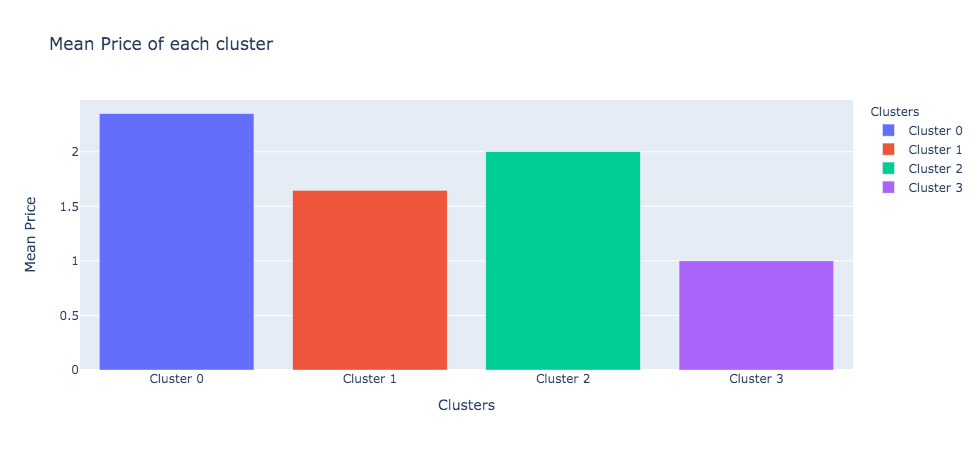

In [518]:

cluster_labels=['Cluster 0','Cluster 1','Cluster 2','Cluster 3']
cluster_mean_price=[cluster1['Price'].mean(),cluster2['Price'].mean(),cluster3['Price'].mean(),cluster4['Price'].mean()]
cluster_price=pd.DataFrame({'Mean Price':cluster_mean_price,'Clusters':cluster_labels})


fig = px.bar(cluster_price, x='Clusters', y='Mean Price',title="Mean Price of each cluster",color="Clusters")
fig.show()


---------

#### The graph above shows cluster 0 and 2 being the most expensive, having entrees ranging from 10-20 USD. If we assume a linear relationship between price rating and real price, Cluster 0 is on average, approximately 17% more expensive than cluster 2 which are the second most expensive venues. 

#### This draws a clear divide between cluster 0 and 2 and cluster 1 and 3. Cluster 0 and 2 are the most expensive venues and clusters 1 and 3 are the cheapest venues, with special attention to cluster 3, which is less than half of the average price of cluster 0. This means that the average price of the entrees of the venues of cluster 3 are less than 10 dollars. 
--------


### The graph below shows a comparison between the mean price (R$) of the real estate in each cluster 

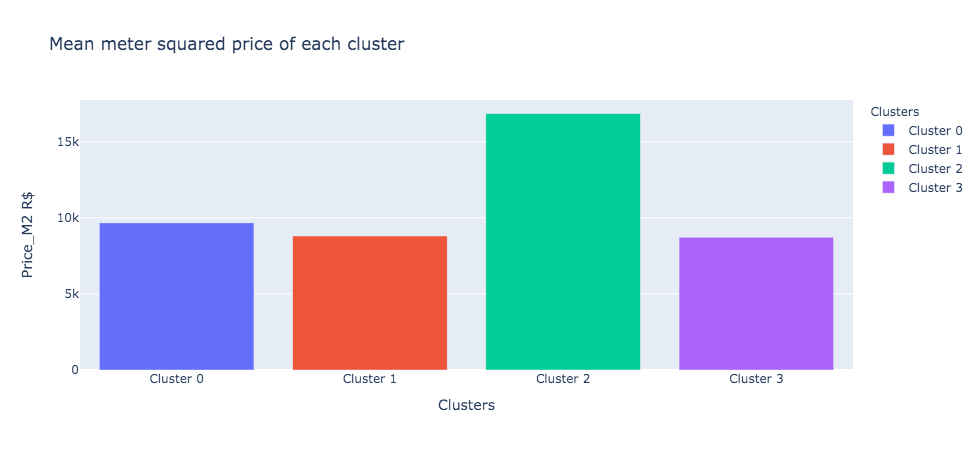

In [519]:
cluster_m2_price=[cluster1['Price_M2'].mean(),cluster2['Price_M2'].mean(),cluster3['Price_M2'].mean(),cluster4['Price_M2'].mean()]
cluster_m2=pd.DataFrame({'Price_M2 R$':cluster_m2_price,'Clusters':cluster_labels})
fig = px.bar(cluster_m2, x='Clusters', y='Price_M2 R$',title="Mean meter squared price of each cluster",color="Clusters"  )
fig.show()


--------
#### The graph above shows that the one of the main clustering feature that separated cluster 2 from the rest was real estate price. Its average price is 75% higher than the second most expensive neighborhood cluster, which is cluster 0. 

#### With this in mind, we expect that the people in cluster 2 have more purchase power compared to other clusters. 

-------

### The graph below shows a comparison between the average rating givem by the customers of each cluster

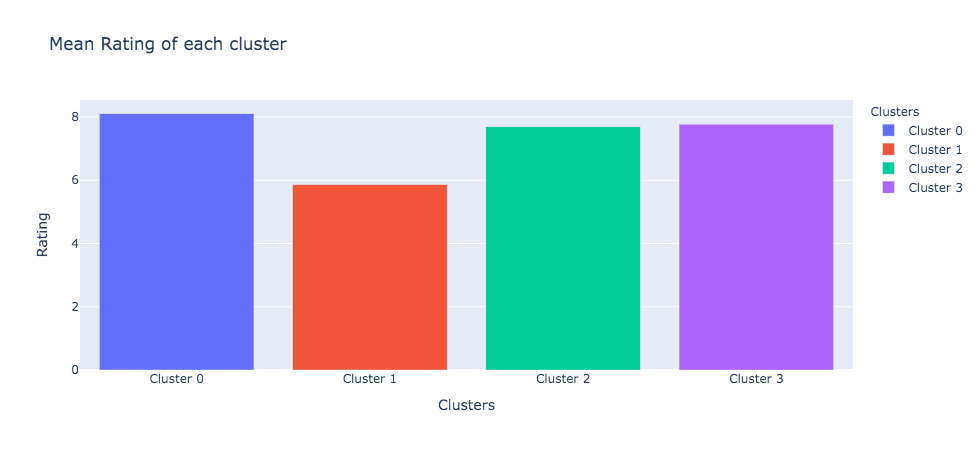

In [464]:

cluster_rating=[cluster1['Rating'].mean(),cluster2['Rating'].mean(),cluster3['Rating'].mean(),cluster4['Rating'].mean()]
cluster_rat=pd.DataFrame({'Rating':cluster_rating,'Clusters':cluster_labels})

fig = px.bar(cluster_rat, x='Clusters', y='Rating',title="Mean Rating of each cluster",color="Clusters"  )
fig.show()

#### Almost all of the clusters had no relevant percentage difference on rating, all of them ranging from 7.6 to 8.1 on average. It's assumable that the venues of these clusters are pretty satisfied customers. 

#### On the other hand, we observe another clear division between clusters on cluster 1. It's average rating was 5.86, 23% less than the second lowest rated cluster. 

-----------------

# __Word Cloud of the clusters__
---------------

### Now we will understand what the customers from the venues of each cluster talk about when it comes to reviews. We do this by identifying the frequency of all the words in the reviews of each venue within the clusters. 

### This will not give us insights about what is particularly best in each cluster but rather will show us what aspects the customers from each cluster care the most. 

### We will do this by creating a word cloud of the reviews of each cluster. 

##### note: Since this project is dealing with a country that speaks portuguese, it will be hard for someone that doesn't understand the language to retain information from the word cloud as a whole. For this reason, I will be explaining and translating some of the key points generated in this word cloud.

In [520]:
#!conda install -c conda-forge wordcloud --yes

# import package and its set of stopwords
from wordcloud import WordCloud, STOPWORDS


### Creating the list of words from the reviews

In [532]:
list_tip1=[]
list_tip2=[]
list_tip3=[]
list_tip4=[]


for i in cluster1['Review']:
    list_tip1.append(i)
for i in cluster2['Review']:
    list_tip2.append(i)
for i in cluster3['Review']:
    list_tip3.append(i)
for i in cluster4['Review']:
    list_tip4.append(i)

flatList1 = [ item for elem in list_tip1 for item in elem]
flatList2 = [ item for elem in list_tip2 for item in elem]
flatList3 = [ item for elem in list_tip3 for item in elem]
flatList4 = [ item for elem in list_tip4 for item in elem]


In [533]:
import numpy as np 
from PIL import Image
unique_string1=(" ").join(flatList1)
unique_string2=(" ").join(flatList2)
unique_string3=(" ").join(flatList3)
unique_string4=(" ").join(flatList4)


burger_mask = np.array(Image.open('burger_mask.png'))

#### Taking some words off that have no meaning

In [565]:
stopwords = ['de','um','tem','na','que','muito','hamburguer',
             'melhor','gostoso','no','com','todo','cardapio',
             'ser','burguer','uma','mas','boa','recomendo','do','os','prato',
             'maravilhoso','mais','em','para','hambúrguer','sem','você','dos',
             'pra','todos','Burguer','não','lanche','da','bom','são','ótimo', 'ao','justo',
             'bem','pode','só','domingo','Sucesso','excelente','pouco','peça','já','se',
             'comi','deixe','hambúrgueres','Burguer',
             'casa','por','cardápio','Vale','Delicioso','vc','fica','lanches',
             'as','foi','Nao','sanduíche','shopping',
             'mediano','Burger','Paulo','MERCADO','pois','nada','menos','Outback','hamburgueria',
             'gostei','daqui','manhã','estao','parte',
             'experimentar','Pena','feitos','quem','Chegar','bons',
             'senha','gotosos','torna','vai','merece','ficar','estão','comida'
             ,'neste','Entre','loja','deliciosos','pub','pelo','demais',
             'também','King','pedida','Meu','anos','tão','tao','aqui','dia','sua','além',
             'nunca','voltar','tive','monta','novo','NaN','food','tv','livre','Prefira','seja','bacana','Boulevard',
             'Aprovado','Quermesse','ótima','safado','orgasmo','favorito','peguei','kkk','Flagstaff','brotos','Virado',
             'cobrar','até','ponto','self','surf','Desde',
             'eu','comercial','divino','minha','precisava','Precisam',
             'Poucas','pedidos','service','melhores','respeito',
             'oleoso','ele','pq','preto','oeferecem','Falta','lugar','negro','repeito','gente','Queria','Hamburger',
             'Parabéns','montados','pegar','split','combinado','bosta','porem',
             'or','cartoon','espetacular','Augusta','your','cuidado','outro','foto','super','aos','kkkk','apesar','the','ou','seu','hora','toque','19h','160g','moelhorando','paladar',
             'jeito','muita','tipo','favor','pressa','deixa','será','friendly','parecem','bueguers','acho','fazer','boas','acima','foda','pau','shhhh','Very','to','embora','trilha',
             'está','JK','me','thru','great','porém','Staff','Louis','caralho','sogro','Vila','vá','mesma','média','elaborada','dez','visita','pela','jus','altos','Chicago',
             'know','kilo','estou','DeBetti','deste','há','amazing','ainda','sempre','provar','confuso','feito','mal','esperando','Ici','mto','pedir','nem','tb','safo','try','ir','feels','Zena','Madeiro','Rs','ravioli','is','DDD','alem','Hoje',
             'SP','and','for','cara','alem','Nesse','saborosa','tamanho','agradável','simples',
             'comer','saboroso','Chico','como','frita','saboroso','tarantino','sensacional','gostosa','11261126','11261126''','guia','vertical','bolinho',
             'leite','vodka','recomenda','vem','cliente','normal','você','conta','sanduiches','isso','horizontal','7h','Prove','voce','boca','fi','balboaburocracia',
             'faca','New','Shots','praticado','incrível','22h','justos','eles','ter',
             'Absolutamente','amor','ás','deveria','dar','agora','estava','deliciosa',
             'ficou','graça','pequenos','australiano','hot','Hot','camarote',
             'Wi','atencioso','tirar','Bolso','engane','lembra','Claro','Tudo','Dog',
             'Nota','Vez','vez','nota','demora','Pior','lá','Experimente','local','servido','macio','região','ruim',
            'Merda','perfeito','das','http','eh','amigo','gosta']




In [566]:
burguer_wc1 = WordCloud(
    background_color='white',
    max_words=2000,
    stopwords=stopwords,
    mask=burger_mask
)

burguer_wc2 = WordCloud(
    background_color='white',
    max_words=2000,
    stopwords=stopwords,
    mask=burger_mask
)

burguer_wc3 = WordCloud(
    background_color='white',
    max_words=2000,
    stopwords=stopwords,
    mask=burger_mask
)

burguer_wc4 = WordCloud(
    background_color='white',
    max_words=2000,
    stopwords=stopwords,
    mask=burger_mask
)

# generate the word cloud
burguer_wc1.generate(unique_string1)
burguer_wc2.generate(unique_string2)
burguer_wc3.generate(unique_string3)
burguer_wc4.generate(unique_string4)



### Plotting the word clouds

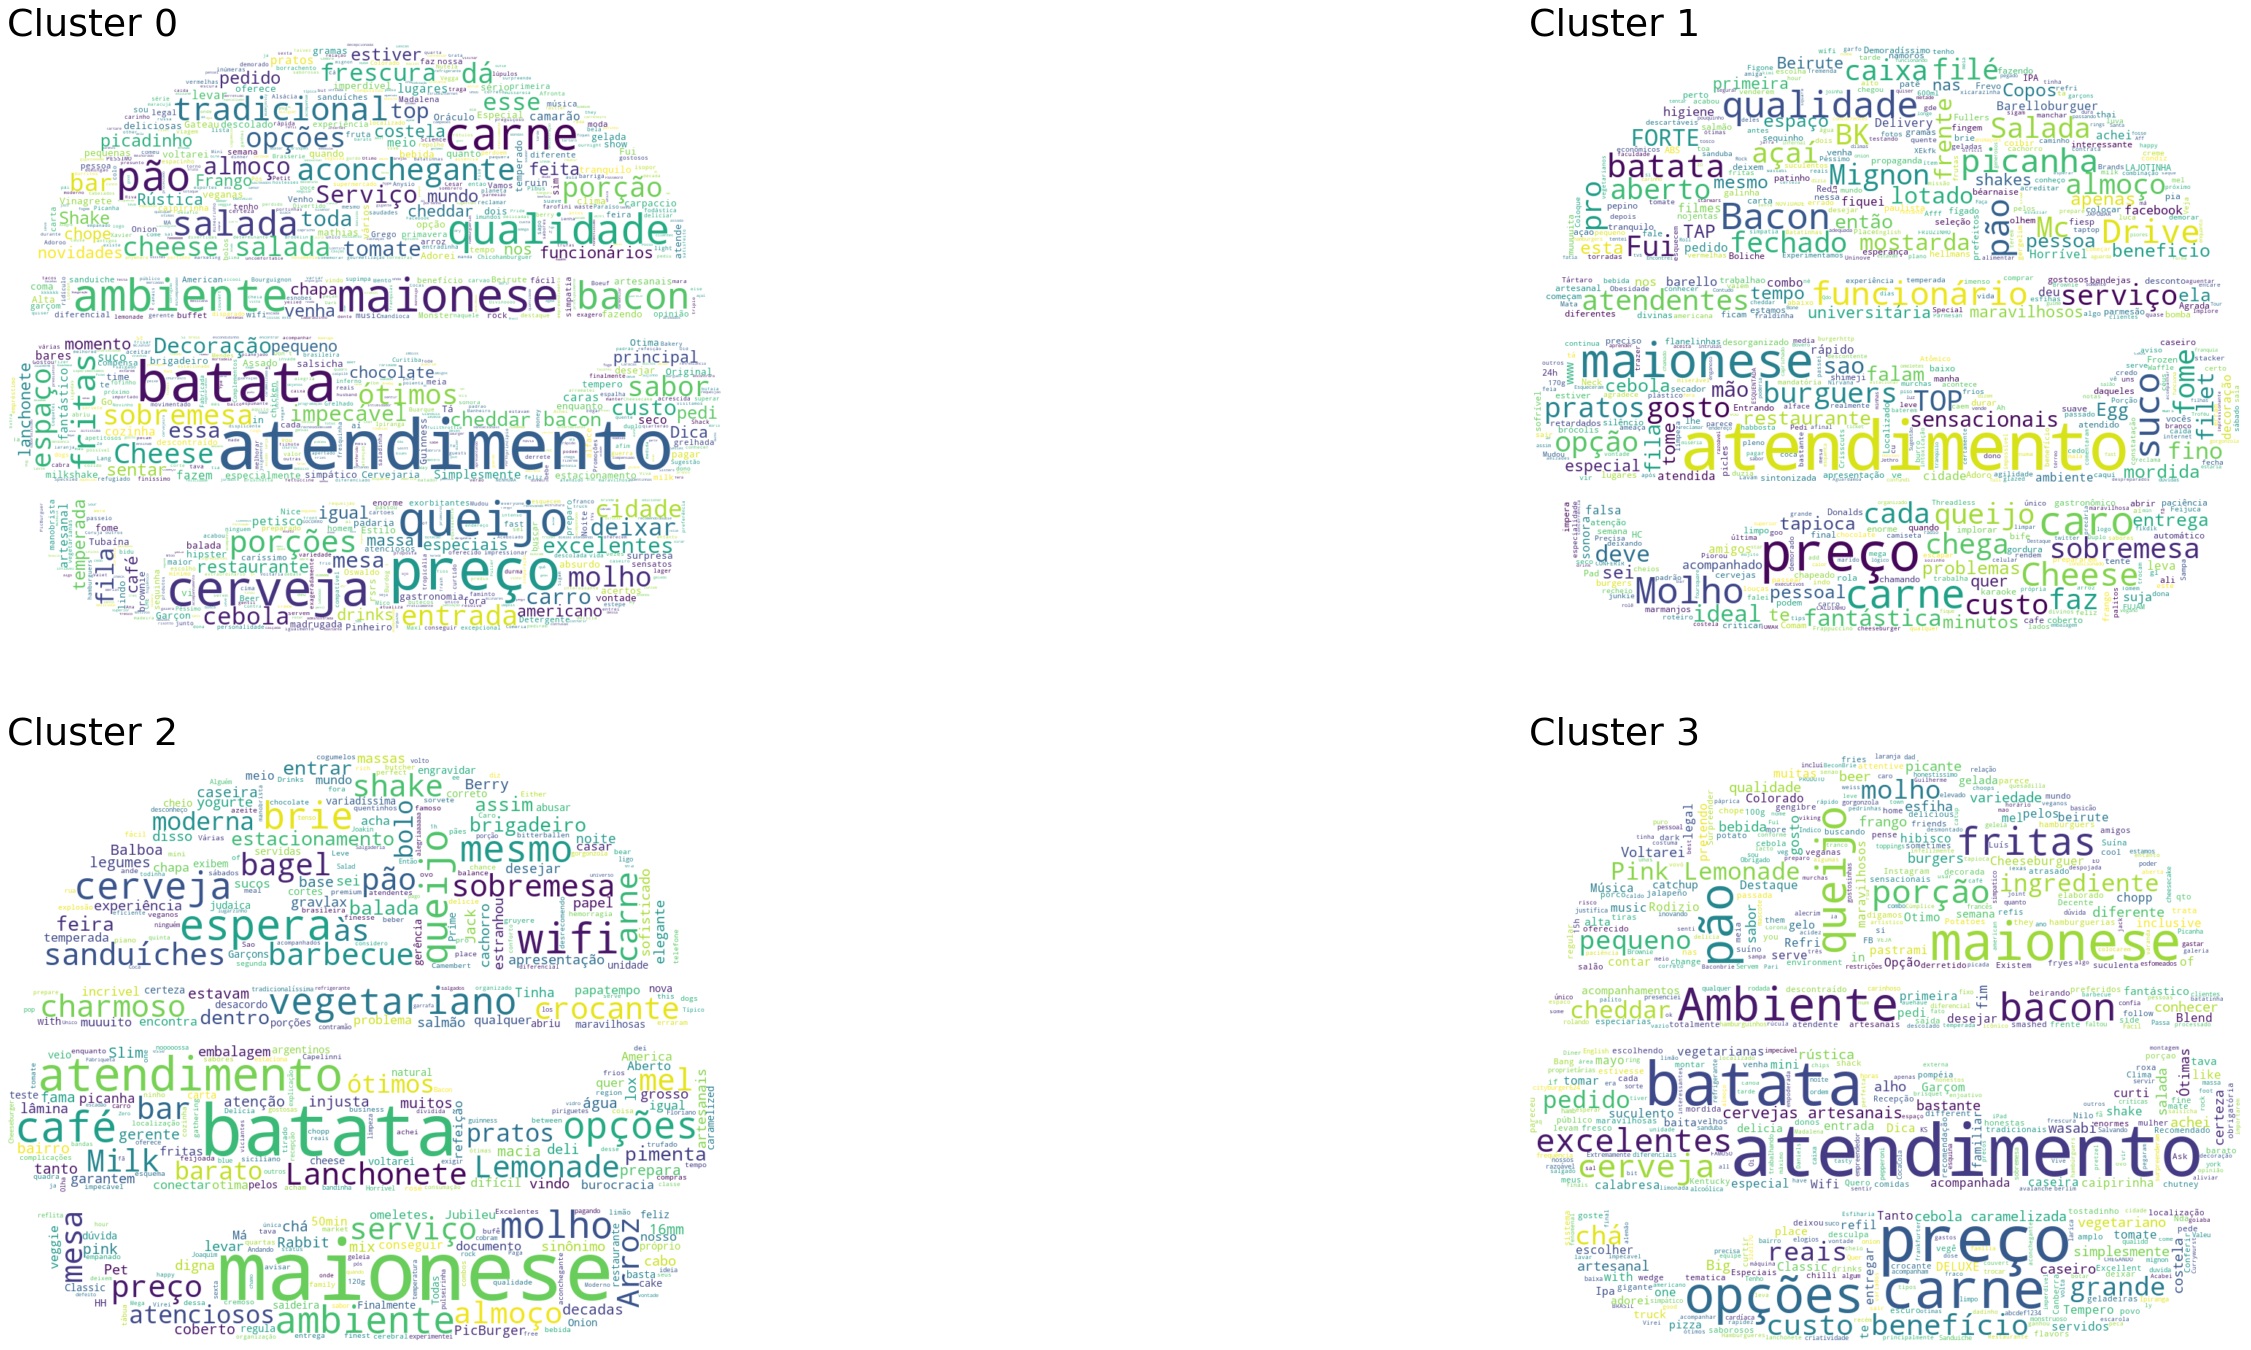

In [567]:
fig = plt.figure()
fig.set_figwidth(50) # set width
fig.set_figheight(50) # set height
fig.add_subplot(4, 2, 1)
plt.axis('off')
plt.title('Cluster 0',fontsize=38,loc='left',verticalalignment='baseline',horizontalalignment= 'left')
plt.imshow(burguer_wc1, interpolation='bilinear')
fig.add_subplot(4, 2, 2)
plt.axis('off')
plt.title('Cluster 1',fontsize=38,loc='left',verticalalignment='baseline',horizontalalignment= 'left')
plt.imshow(burguer_wc2, interpolation='bilinear')
fig.add_subplot(4, 2, 3)
plt.axis('off')
plt.title('Cluster 2',fontsize=38,loc='left',verticalalignment='baseline',horizontalalignment= 'left')
plt.imshow(burguer_wc3, interpolation='bilinear')
fig.add_subplot(4, 2, 4)
plt.axis('off')
plt.title('Cluster 3',fontsize=38,loc='left',verticalalignment='baseline',horizontalalignment= 'left')
plt.imshow(burguer_wc4, interpolation='bilinear')



### These word clouds will bring us insights about what is being said by the customers in all clusters. 

In [538]:
wc1=pd.DataFrame(burguer_wc1.words_,index=[0]).transpose()
wc2=pd.DataFrame(burguer_wc2.words_,index=[0]).transpose()

wc3=pd.DataFrame(burguer_wc3.words_,index=[0]).transpose()
wc4=pd.DataFrame(burguer_wc4.words_,index=[0]).transpose()


### We retrieve the 10 top words from each cluster based on their frequency

In [560]:
print('Cluster 0:\n',wc1.head(10),'\n''--------------------')
print('Cluster 1:\n',wc2.head(10),'\n''--------------------')
print('Cluster 2:\n',wc3.head(10),'\n''--------------------')
print('Cluster 3:\n',wc4.head(10),'\n''--------------------')

Cluster 0:
                     0
atendimento  1.000000
preço        0.636364
batata       0.606061
cerveja      0.484848
queijo       0.454545
maionese     0.424242
carne        0.393939
ambiente     0.393939
pão          0.333333
qualidade    0.333333 
--------------------
Cluster 1:
                     0
atendimento  1.000000
preço        0.578947
maionese     0.473684
carne        0.315789
caro         0.315789
Molho        0.263158
Bacon        0.263158
suco         0.263158
qualidade    0.263158
picanha      0.210526 
--------------------
Cluster 2:
                     0
maionese     1.000000
batata       0.714286
atendimento  0.714286
wifi         0.571429
café         0.571429
espera       0.571429
vegetariano  0.428571
queijo       0.428571
brie         0.428571
ambiente     0.428571 
--------------------
Cluster 3:
                     0
atendimento  1.000000
preço        0.782609
batata       0.695652
carne        0.565217
maionese     0.521739
opções       0.478261
Ambien

-----
#### From this section, we can identify some simmilarities between the information we gathered in the previous steps while analyzing the clusters quantitatively. 

#### First lets take a look at everything they have in common within their top ranked words, these could be the must-haves for someone looking to open a burguer joint. All of them have the word 'atendimento' which means 'service' in portuguese. So first key takeway from this information is that no matter your customer segment, price, or location, you have to have a good service, this word is within the top 3 words in all clusters. Another word that appeared in all clusters is 'maionese' which you would probably guess as being mayonnese. 

#### Now, taking a look at the differences between clusters, we can see that all of them but cluster 2 have the word 'preço',which means 'price' in portuguese. This means that cluster 2 probablly doesn't show too much interest in evaluating price as a deifining category when visiting a burguer joint. This makes sense based on the price per meter squared because cluster 2 was categorized as having the richest customers. Another interesting fact is that cluster 2 referes to the word vegetarian ('vegetariano' in portuguese) and brie (as for the cheese), showing that they are also very demanding.

#### There are tons of insights to take away from these top 10 words. I will go in a deeper analysis in the blog post about this project. For now, I will keep the analysis on the more discrepant points between the clusters. 

#### Bellow there is a list of the words in english

--------

##### Cluster 0:
##### -------                     
##### service      1.000000
##### price        0.636364
##### fries        0.606061
##### beer         0.484848
##### cheese       0.454545
##### mayo         0.424242
##### meat         0.393939
##### environment  0.393939
##### bread        0.333333
##### quality      0.333333

##### --------------------
##### Cluster 1:
##### -------                       
##### service      1.000000
##### price        0.578947
##### mayo         0.473684
##### meat         0.315789
##### expensive    0.315789
##### sauce        0.263158
##### bacon        0.263158
##### juice        0.263158
##### quality      0.263158
##### picanha      0.210526 

##### --------------------
##### Cluster 2:
##### -------                       
##### mayo         1.000000
##### fires        0.714286
##### service      0.714286
##### wifi         0.571429
##### coffee       0.571429
##### waiting      0.571429
##### vegetarian   0.428571
##### cheese       0.428571
##### brie         0.428571
##### environment  0.428571 

##### --------------------
##### Cluster 3:
##### -------                       
##### service      1.000000
##### price        0.782609
##### fries        0.695652
##### meat         0.565217
##### mayo         0.521739
##### options      0.478261
##### environment  0.434783
##### bread        0.434783
##### cheese       0.347826
##### fries        0.304348 

##### --------------------

----------------

# __Conclusion__

-------------

#### All of this information gathered about the venues and analysis on them gave us a plethora of insights. Although unsupervised algorithms are not always reliable, they proved to show us some insights and help not only segment the venues but also take a deep look into the customers of these venues. From the clusters per se, the key take aways from them are: 

- Cluster 0: High priced venues, on neighborhoods that are average priced and have high ratings. The customers talk about the price, service and another feature that was not present in any other category which is beer. This shows us that the people that attend these high priced venues don't have as much purchasing power as cluster 2 but when they choose to spend, money, it is probably on __leisure time (hence beer on top words) and they value this type of experience (hence higher ratings)__.

- Cluster 1: Average priced (compared to others), low priced neighborhoods and low ratings. This cluster is highlighted by dissatisfaction not only in the ratings but in the top words where price and expensive are among the top 10. This could be explained by the fact that people within this cluster don't have much purchasing power and when they try to spend a little bit more on average priced venues, they usually don't reach their expectations. Points that a cluster 1 venue should look out for are probably __cost benefit related, giving people expectations that are not really met__.  

- Cluster 2: High priced venues and neighborhood locations and high ratings. This cluster is defined by high standards and and differentiation. One explanation for the rating being lower than clusters 0 and 3 are that people that have higher purschasing power and attend high priced venues elevate their expectations, hence, they will have less mercy when submitting a rating. Based on the top words, we can see that the customers of these venues pay attention to differentiated foods and condiments and place mayo as the top word. A clear point that cluster 2 venues should look out for are clearly to place a __priority on uniqueness within their venue's menu, with less regards when it comes to pricing__. 

- Cluster 3: Low priced venues in low priced neighborhoods with high ratings. This cluster is about having lower prices and getting what you paid for. One aspect that was not discussed but is a word that appears on the 15th place on the word cloud is cost-benefit. This already shows us that the customers are getting what they are looking for: good price for a good meal. The price frequency on the cluster 3 word cloud was grater than all the others and from there the top words highlight the basic aspects of a burger joint which is fries,meat, mayo and lots of options. The key take-away for cluster 3 venues is: __keep it simple and cheap__.


#### This closes up the study on burger joints in São Paulo. There are tons of data that could make this study more reliable statistically and probably a supervised algorithm would be a good choice if we could label the venues. With that said, it is a good high level analysis of the burger joint market in São Paulo for people that are thinking of opening up a burguer joint or for people that are curious about how data science and machine learning can help us retrieve insights and learn new things about almost every topic.

# Appendix: Using K-Prototypes

---------
## __K-Prototypes quick explanation__


### The __k-prototypes__ algorithm is basically a k-means and k-modes binded together. The k-means will use euclidean distance to calculate dissimilarity between intracluster elements and k-modes will calcultate the distance based on the mode of the features in each individual to calculate the dissimilarity between categorical features. 

### The dissimilarity function of the k-prototypes can be represented by: S+γP, where S is the dissimilarity of the numeric atributes and P is the dissimilarities between the categorical attributes. Gamma (γ) is the weight that the categorical attributes will have in our clustering algorithm. Of course this is an over simplification of the algorithm so make sure to chek out the article piblished by Zhexue Huang included in the bibliography below.

---------

#### __We re-scale our meter squared data for it to be aproximately in the same range as the rating__

In [568]:
scaler = MinMaxScaler(feature_range=(0, 10))
price_M2=cluster_df['Price_M2']
price_M2=price_M2.to_numpy()
price_M2=price_M2.reshape(-1, 1)
price_M2_scaled=scaler.fit_transform(price_M2)
price_M2_scaled=pd.DataFrame(price_M2_scaled)
price_M2_scaled.reset_index(drop=True,inplace=True)
cluster_scaled=cluster_df.filter(['Rating','Price'], axis=1)
cluster_scaled.reset_index(drop=True,inplace=True) 



In [569]:
cluster_scaled=cluster_scaled.join(pd.DataFrame(price_M2_scaled))
cluster_scaled.columns = ['Rating', 'Price_Scale','Price_M2']

### First we will run our clustering algorith with different values of K and use the elbow technique to choose the best k for our case.

##### note: in this study, to preserve the information in the ordering of the rating, we will consider it to be a continuous variable, although its actually an ordinal variable

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 0, ncost: 1614.2105529803714
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 0, ncost: 796.4839796815952
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 52, ncost: 977.9524566860762
Run: 1, iteration: 2/100, moves: 72, ncost: 816.0245416103959
Run: 1, iteration: 3/100, moves: 74, ncost: 635.0887197818618
Run: 1, iteration: 4/100, moves: 27, ncost: 564.3049700830114
Run: 1, iteration: 5/100, moves: 18, ncost: 553.3109629818631
Run: 1, iteration: 6/100, moves: 13, ncost: 547.6435911325383
Run: 1, iteration: 7/100, moves: 10, ncost: 538.1890318852038
Run: 1, iteration: 8/100, moves: 11, ncost: 534.9922823757686
Run: 1, iteration: 9/100, moves: 4, ncost: 534.4508386364106
Run: 1, iteration: 10/100, moves: 0, ncost: 534.4508386364106
Init: initializing

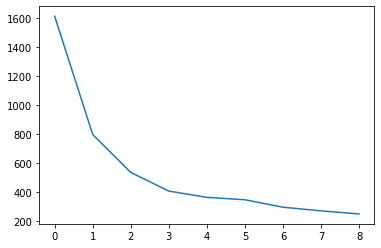

In [570]:
cost = []
K = range(1,10)
for k in K:
    kp=KPrototypes(n_clusters=k, init='Huang', n_init=1, verbose=2)
    clusters = kp.fit_predict(cluster_scaled, categorical=[1])
    cost.append(kp.cost_)
plt.plot(cost)


### Using the elbow technique, we found that 2 clusters would be the best choice to cluster our burger venues

In [575]:
#from sklearn import metrics
from sklearn.metrics import silhouette_score
nclusters=2
kp=KPrototypes(n_clusters=nclusters, init='Huang', n_init=1, verbose=2)
clusters = kp.fit_predict(cluster_scaled, categorical=[1])


Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 0, ncost: 796.4839796815952


#### The analysis of the data is out of the scope of this project, but I will present all the graphs and results using k-prototypes

In [576]:
SP_kproto_venues=SP_burguer_venues
SP_kproto_venues.drop(columns=['Cluster Labels'],inplace=True)
SP_venues_kproto_clustered=SP_kproto_venues.insert(0, 'Cluster Labels', clusters)

In [577]:
map_kproto_clusters = folium.Map(location=[latitudeSP,longitudeSP], zoom_start=11)

# set color scheme for the clusters
x = np.arange(nclusters)
ys = [i + x + (i*x)**2 for i in range(nclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(SP_kproto_venues['Venue Latitude'], SP_kproto_venues['Venue Longitude'], SP_kproto_venues['Neighborhood'], SP_kproto_venues['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_kproto_clusters)
       
map_kproto_clusters

In [578]:
cluster_kproto_1=SP_kproto_venues.loc[SP_kproto_venues['Cluster Labels'] == 0]
cluster_kproto_1.reset_index(drop=True,inplace=True)
cluster_kproto_2=SP_kproto_venues.loc[SP_kproto_venues['Cluster Labels'] == 1]

In [579]:
import plotly
import plotly.express as px
fig = px.scatter_3d(SP_kproto_venues, x='Rating', y='Price', z='Price_M2',
              color='Cluster Labels', size_max=18,
               opacity=0.7)

fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()

### The mean Price

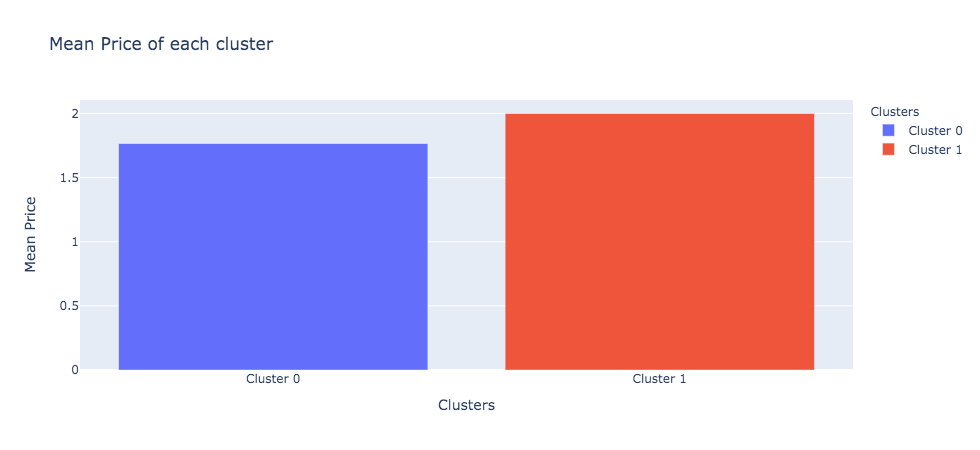

In [581]:
cluster_labels_kproto=['Cluster 0','Cluster 1']
cluster_mean_price_kproto=[cluster_kproto_1['Price'].mean(),cluster_kproto_2['Price'].mean()]
cluster_price_kproto=pd.DataFrame({'Mean Price':cluster_mean_price_kproto,'Clusters':cluster_labels_kproto})


fig = px.bar(cluster_price_kproto, x='Clusters', y='Mean Price',title="Mean Price of each cluster",color="Clusters")
fig.show()


### The graph below shows a comparison between the mean price (R$) of the real estate in each cluster 

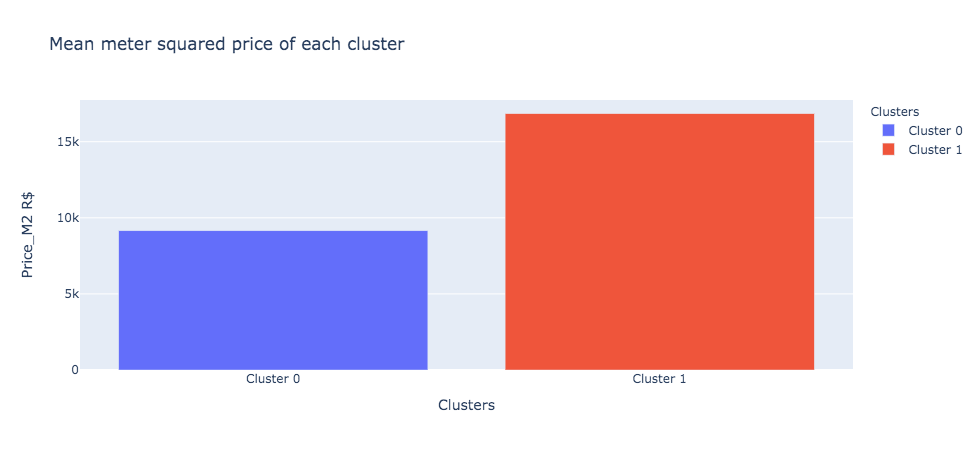

In [582]:
cluster_m2_price_kproto=[cluster_kproto_1['Price_M2'].mean(),cluster_kproto_2['Price_M2'].mean()]
cluster_m2_kproto=pd.DataFrame({'Price_M2 R$':cluster_m2_price_kproto,'Clusters':cluster_labels_kproto})
fig = px.bar(cluster_m2_kproto, x='Clusters', y='Price_M2 R$',title="Mean meter squared price of each cluster",color="Clusters"  )
fig.show()


### The graph below shows a comparison between the average rating givem by the customers of each cluster

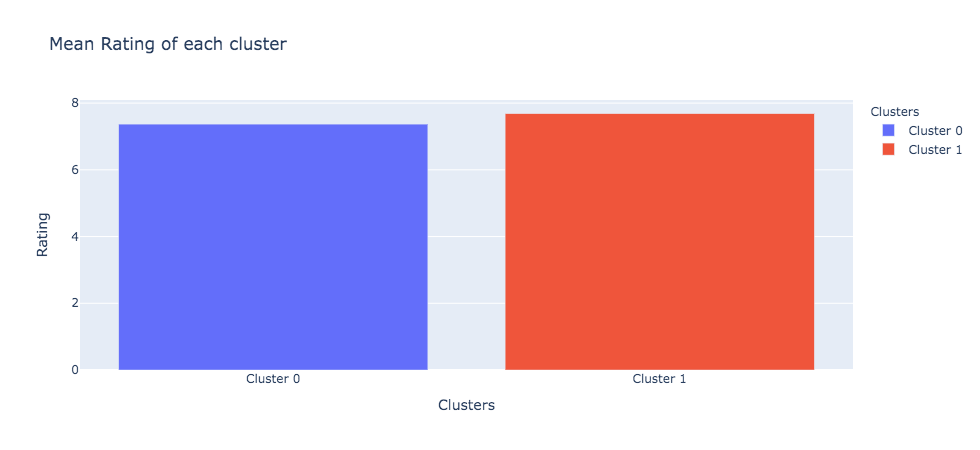

In [583]:

cluster_rating_kproto=[cluster_kproto_1['Rating'].mean(),cluster_kproto_2['Rating'].mean()]
cluster_rat_kproto=pd.DataFrame({'Rating':cluster_rating_kproto,'Clusters':cluster_labels_kproto})

fig = px.bar(cluster_rat_kproto, x='Clusters', y='Rating',title="Mean Rating of each cluster",color="Clusters"  )
fig.show()

### __Now the word clouds__

#### Creating the list of words from the reviews

In [591]:
list_tip1_kproto=[]
list_tip2_kproto=[]



for i in cluster_kproto_1['Review']:
    list_tip1_kproto.append(i)
for i in cluster_kproto_2['Review']:
    list_tip2_kproto.append(i)

flatList1_kproto = [ item for elem in list_tip1_kproto for item in elem]
flatList2_kproto = [ item for elem in list_tip2_kproto for item in elem]


In [592]:
import numpy as np 
from PIL import Image
unique_string1_kproto=(" ").join(flatList1_kproto)
unique_string2_kproto=(" ").join(flatList2_kproto)


burger_mask = np.array(Image.open('burger_mask.png'))

#### Taking some words off that have no meaning

In [593]:
stopwords = ['de','um','tem','na','que','muito','hamburguer',
             'melhor','gostoso','no','com','todo','cardapio',
             'ser','burguer','uma','mas','boa','recomendo','do','os','prato',
             'maravilhoso','mais','em','para','hambúrguer','sem','você','dos',
             'pra','todos','Burguer','não','lanche','da','bom','são','ótimo', 'ao','justo',
             'bem','pode','só','domingo','Sucesso','excelente','pouco','peça','já','se',
             'comi','deixe','hambúrgueres','Burguer',
             'casa','por','cardápio','Vale','Delicioso','vc','fica','lanches',
             'as','foi','Nao','sanduíche','shopping',
             'mediano','Burger','Paulo','MERCADO','pois','nada','menos','Outback','hamburgueria',
             'gostei','daqui','manhã','estao','parte',
             'experimentar','Pena','feitos','quem','Chegar','bons',
             'senha','gotosos','torna','vai','merece','ficar','estão','comida'
             ,'neste','Entre','loja','deliciosos','pub','pelo','demais',
             'também','King','pedida','Meu','anos','tão','tao','aqui','dia','sua','além',
             'nunca','voltar','tive','monta','novo','NaN','food','tv','livre','Prefira','seja','bacana','Boulevard',
             'Aprovado','Quermesse','ótima','safado','orgasmo','favorito','peguei','kkk','Flagstaff','brotos','Virado',
             'cobrar','até','ponto','self','surf','Desde',
             'eu','comercial','divino','minha','precisava','Precisam',
             'Poucas','pedidos','service','melhores','respeito',
             'oleoso','ele','pq','preto','oeferecem','Falta','lugar','negro','repeito','gente','Queria','Hamburger',
             'Parabéns','montados','pegar','split','combinado','bosta','porem',
             'or','cartoon','espetacular','Augusta','your','cuidado','outro','foto','super','aos','kkkk','apesar','the','ou','seu','hora','toque','19h','160g','moelhorando','paladar',
             'jeito','muita','tipo','favor','pressa','deixa','será','friendly','parecem','bueguers','acho','fazer','boas','acima','foda','pau','shhhh','Very','to','embora','trilha',
             'está','JK','me','thru','great','porém','Staff','Louis','caralho','sogro','Vila','vá','mesma','média','elaborada','dez','visita','pela','jus','altos','Chicago',
             'know','kilo','estou','DeBetti','deste','há','amazing','ainda','sempre','provar','confuso','feito','mal','esperando','Ici','mto','pedir','nem','tb','safo','try','ir','feels','Zena','Madeiro','Rs','ravioli','is','DDD','alem','Hoje',
             'SP','and','for','cara','alem','Nesse','saborosa','tamanho','agradável','simples',
             'comer','saboroso','Chico','como','frita','saboroso','tarantino','sensacional','gostosa','11261126','11261126''','guia','vertical','bolinho',
             'leite','vodka','recomenda','vem','cliente','normal','você','conta','sanduiches','isso','horizontal','7h','Prove','voce','boca','fi','balboaburocracia',
             'faca','New','Shots','praticado','incrível','22h','justos','eles','ter',
             'Absolutamente','amor','ás','deveria','dar','agora','estava','deliciosa',
             'ficou','graça','pequenos','australiano','hot','Hot','camarote',
             'Wi','atencioso','tirar','Bolso','engane','lembra','Claro','Tudo','Dog',
             'Nota','Vez','vez','nota','demora','Pior','lá','Experimente','local','servido','macio','região','ruim',
            'Merda','perfeito','das','http','eh','amigo','gosta']




In [594]:
burguer_wc1_kproto = WordCloud(
    background_color='white',
    max_words=2000,
    stopwords=stopwords,
    mask=burger_mask
)

burguer_wc2_kproto = WordCloud(
    background_color='white',
    max_words=2000,
    stopwords=stopwords,
    mask=burger_mask
)


# generate the word cloud
burguer_wc1_kproto.generate(unique_string1_kproto)
burguer_wc2_kproto.generate(unique_string2_kproto)



### Plotting the word clouds

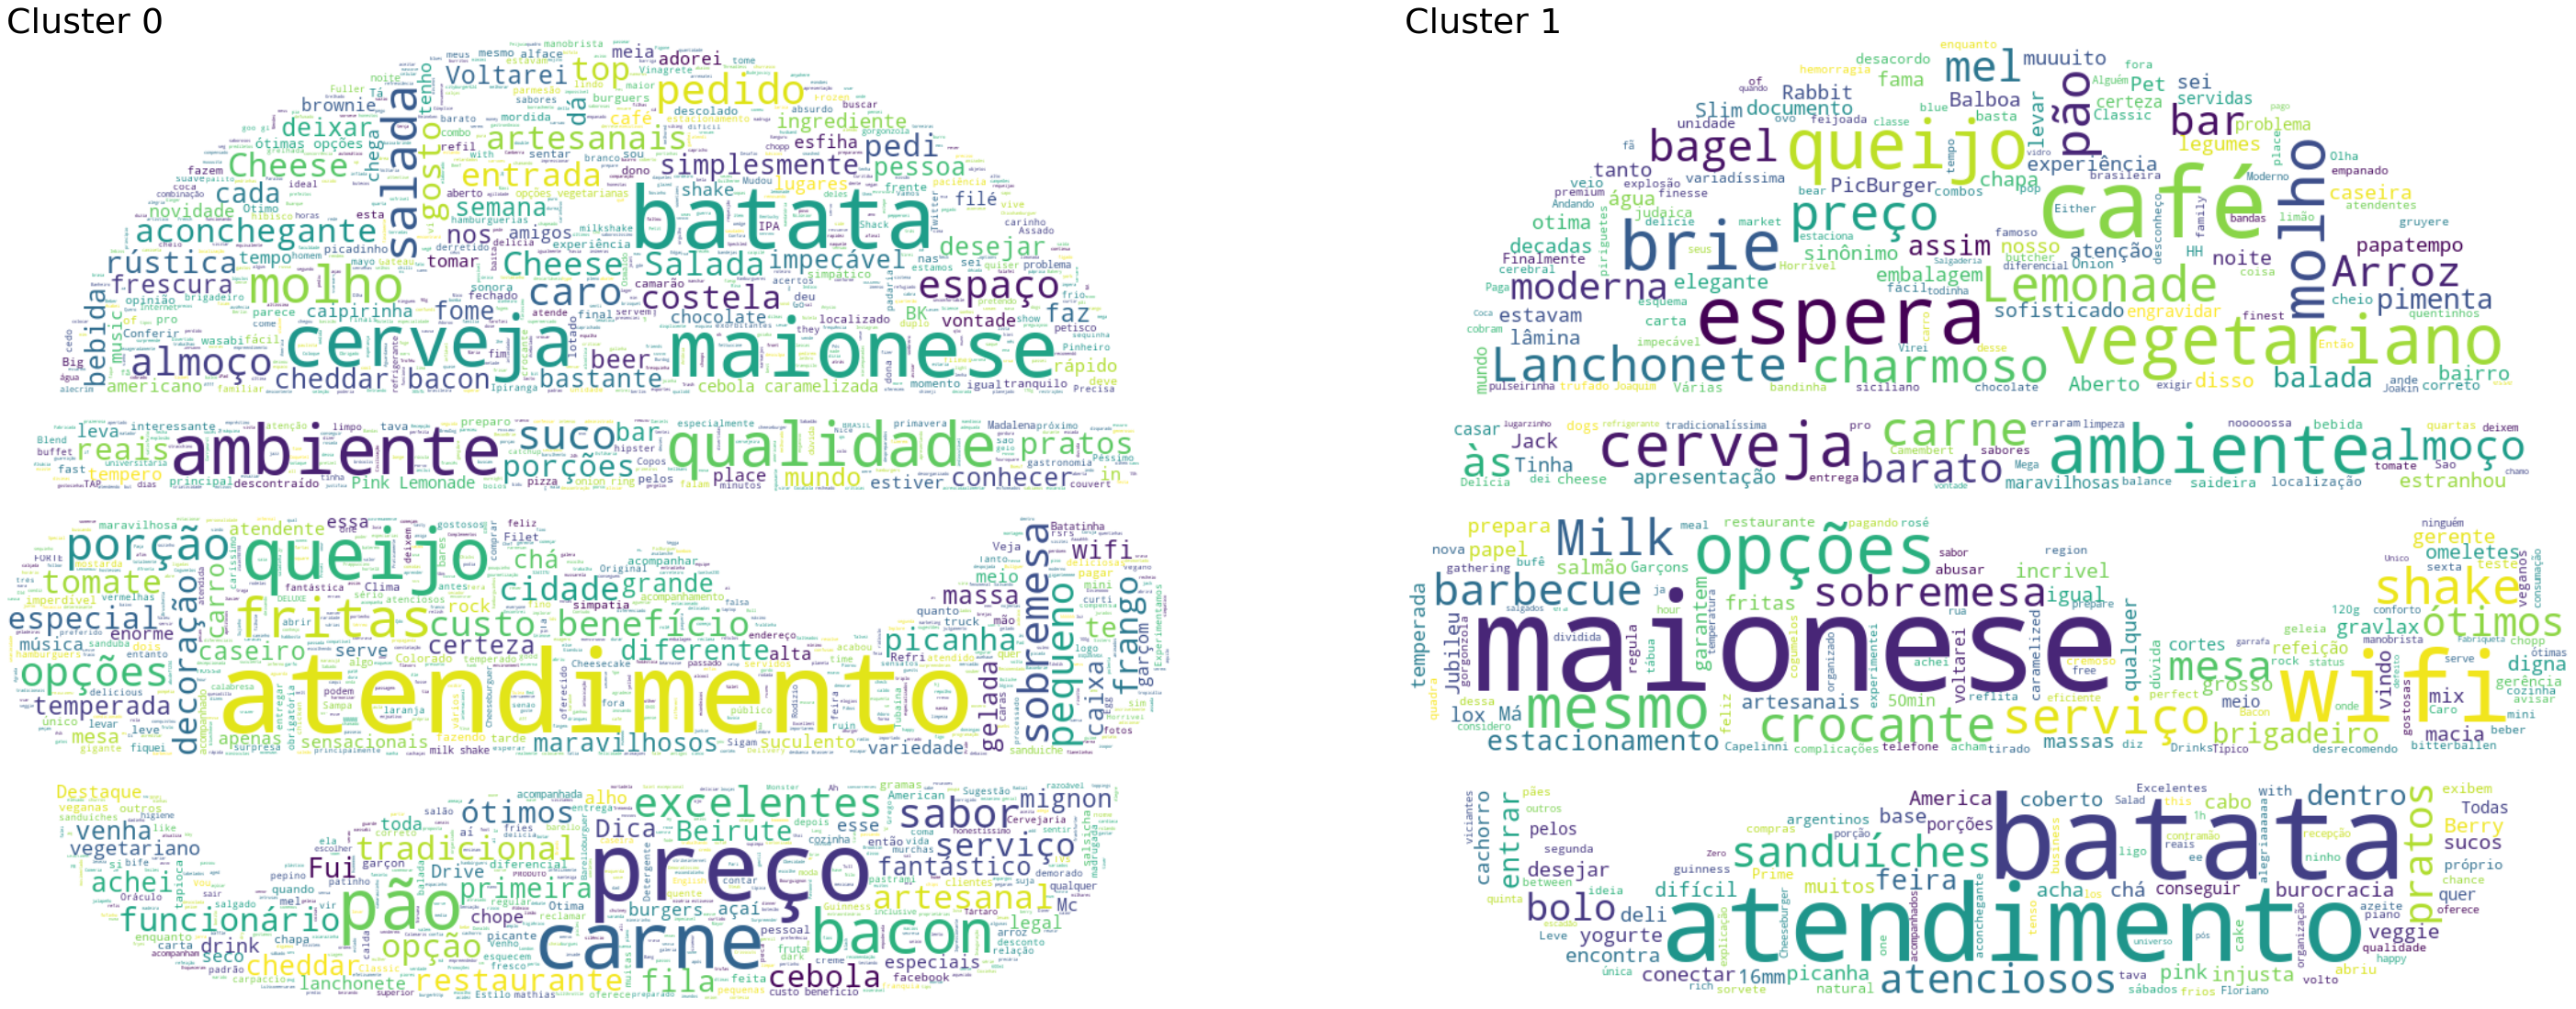

In [595]:
fig = plt.figure()
fig.set_figwidth(50) # set width
fig.set_figheight(50) # set height
fig.add_subplot(2, 2, 1)
plt.axis('off')
plt.title('Cluster 0',fontsize=38,loc='left',verticalalignment='baseline',horizontalalignment= 'left')
plt.imshow(burguer_wc1_kproto, interpolation='bilinear')
fig.add_subplot(2, 2, 2)
plt.axis('off')
plt.title('Cluster 1',fontsize=38,loc='left',verticalalignment='baseline',horizontalalignment= 'left')
plt.imshow(burguer_wc2_kproto, interpolation='bilinear')



### These word clouds will bring us insights about what is being said by the customers in all clusters. 

In [596]:
wc1_kproto=pd.DataFrame(burguer_wc1_kproto.words_,index=[0]).transpose()
wc2_kproto=pd.DataFrame(burguer_wc2_kproto.words_,index=[0]).transpose()


#### We retrieve the 10 top words from each cluster based on their frequency

In [597]:
print('Cluster 0:\n',wc1_kproto.head(10),'\n''--------------------')
print('Cluster 1:\n',wc2_kproto.head(10),'\n''--------------------')


Cluster 0:
                     0
atendimento  1.000000
preço        0.666667
batata       0.533333
maionese     0.466667
carne        0.426667
queijo       0.346667
cerveja      0.346667
ambiente     0.333333
pão          0.333333
bacon        0.253333 
--------------------
Cluster 1:
                     0
maionese     1.000000
batata       0.714286
atendimento  0.714286
wifi         0.571429
café         0.571429
espera       0.571429
vegetariano  0.428571
queijo       0.428571
brie         0.428571
ambiente     0.428571 
--------------------


#### Words translated

##### Cluster 0:
                     
##### service      1.000000
##### price        0.666667
##### fries        0.533333
##### mayo         0.466667
##### meat         0.426667
##### cheese       0.346667
##### beer         0.346667
##### environment  0.333333
##### bread        0.333333
##### bacon        0.253333 

##### --------------------
##### Cluster 1:
                     
##### mayo         1.000000
##### fries        0.714286
##### service      0.714286
##### wifi         0.571429
##### coffee       0.571429
##### waiting      0.571429
##### vegetarian   0.428571
##### cheese       0.428571
##### brie         0.428571
##### environment  0.428571 
##### --------------------

--------

# __References and Bibliography__

------

##### HUANG, ZHEXUE. Extensions to the K-Means Algorithm for Clustering Large Data Sets with Categorical Values. Jan. 1998, http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.15.4028&#38;rep=rep1&#38;type=pdf.

##### A Melhor Plataforma Para a Venda e Compra Direta. proprietariodireto.com.br/.

##### Foursquare Developer. developer.foursquare.com/.